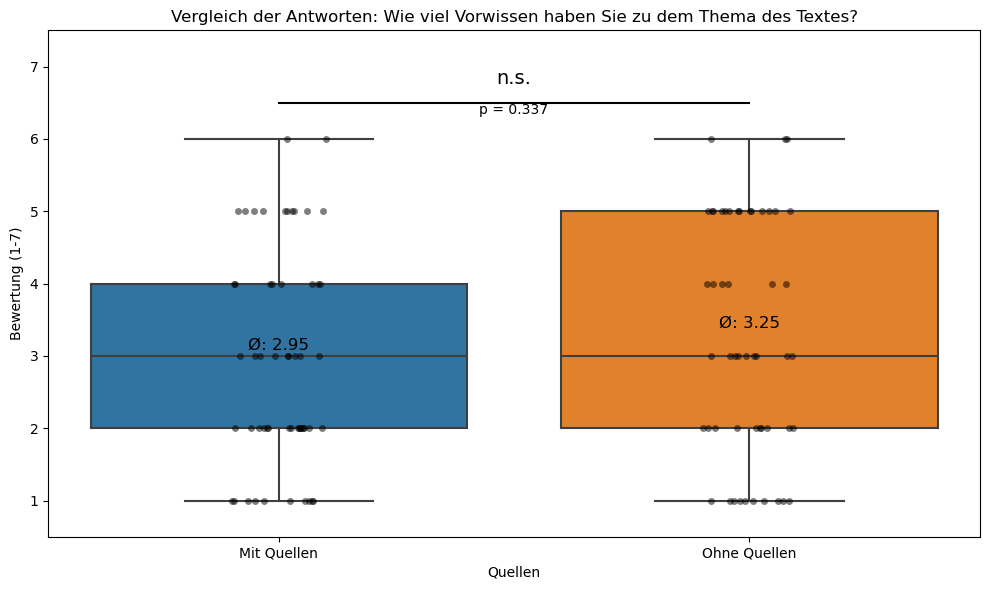

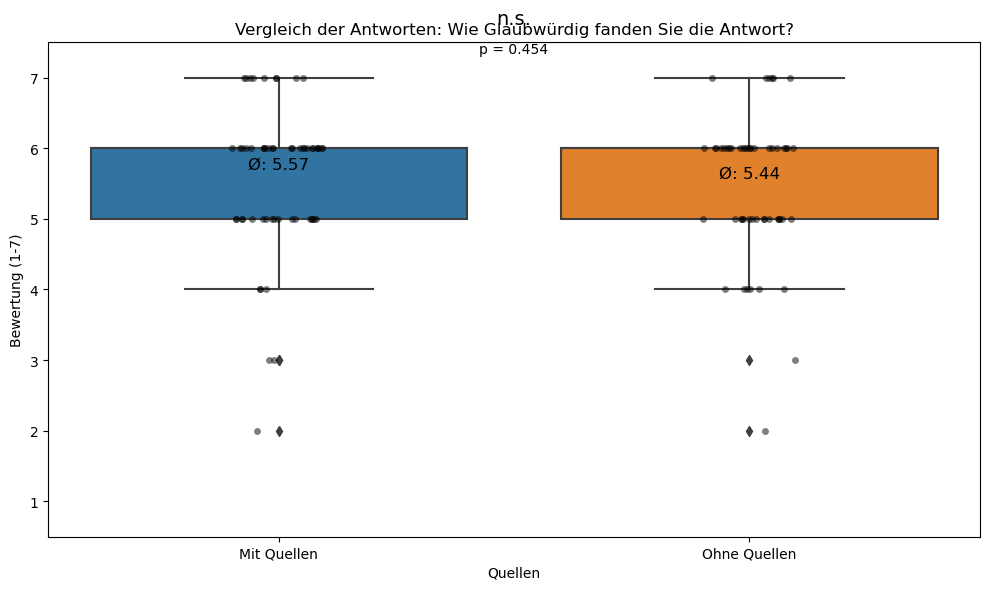

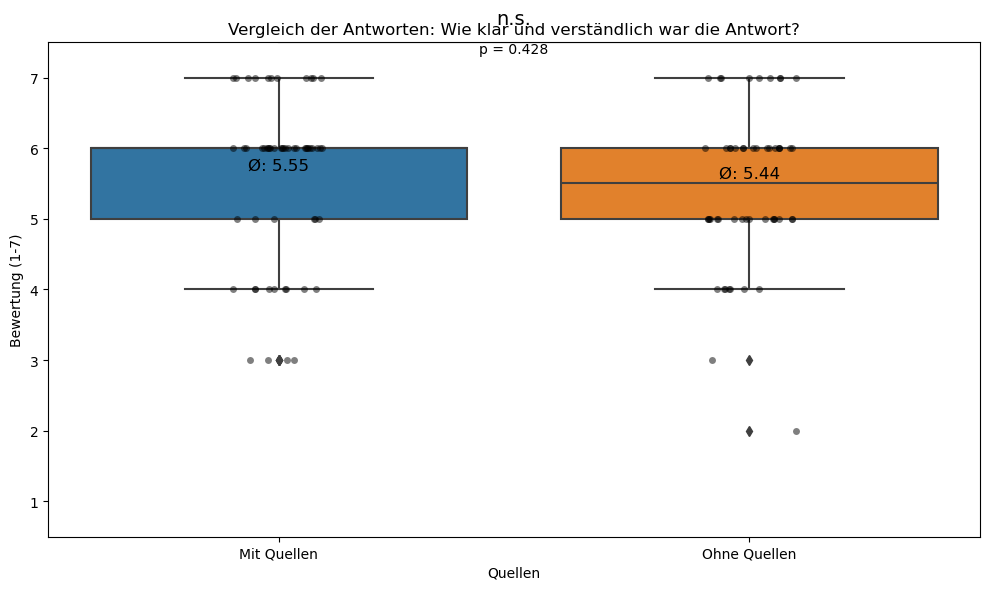

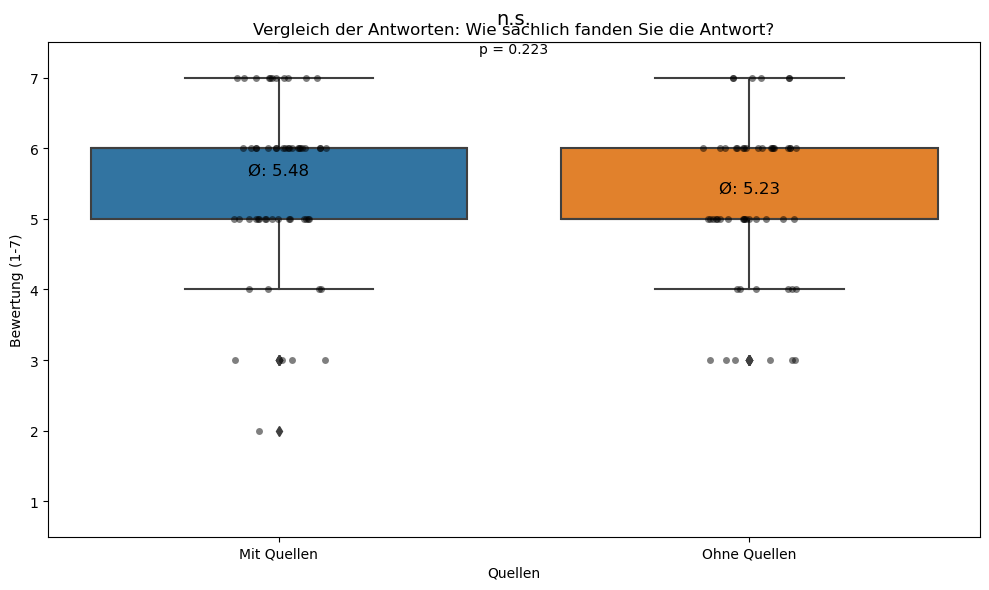

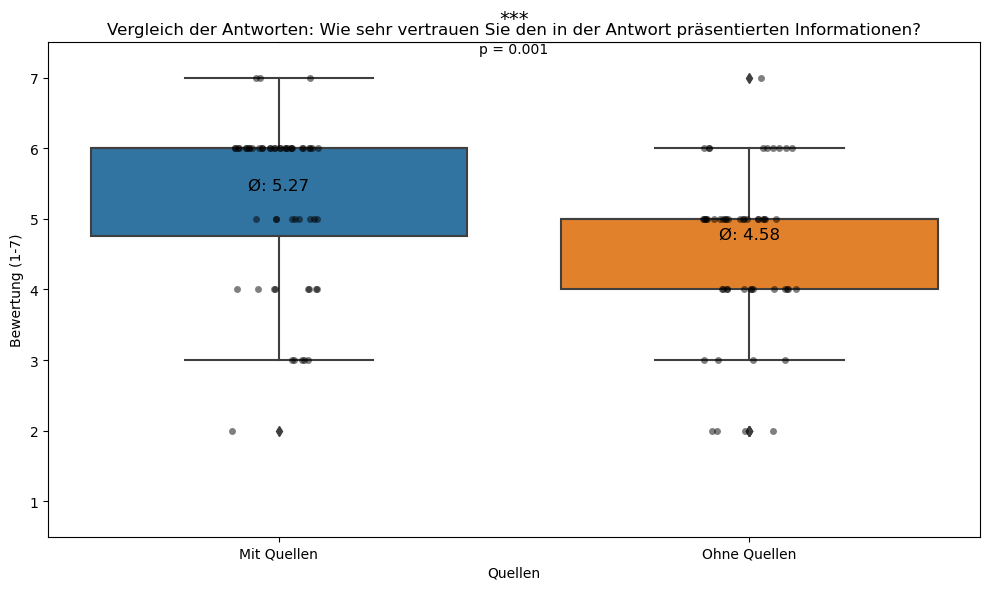

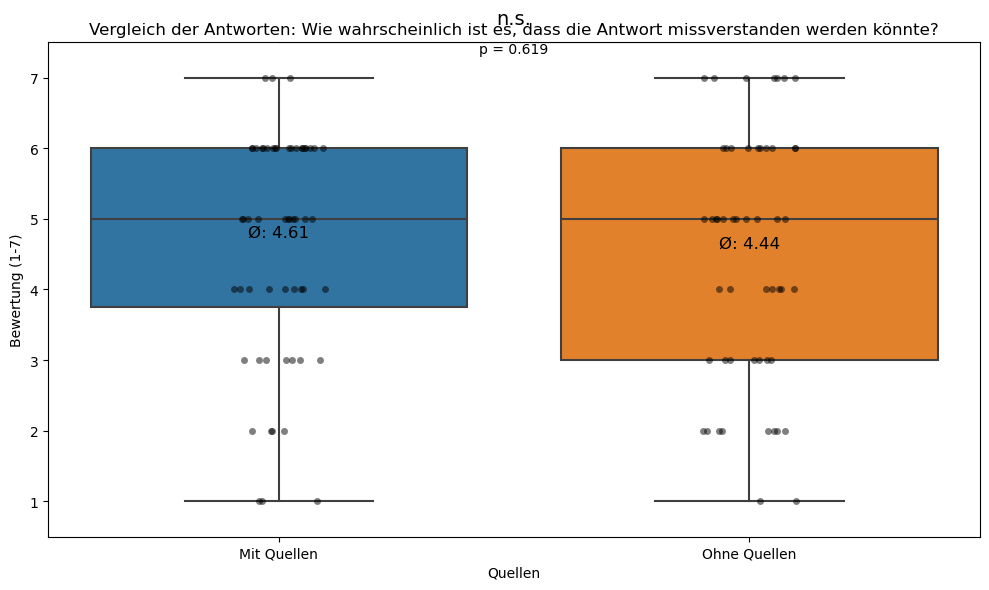

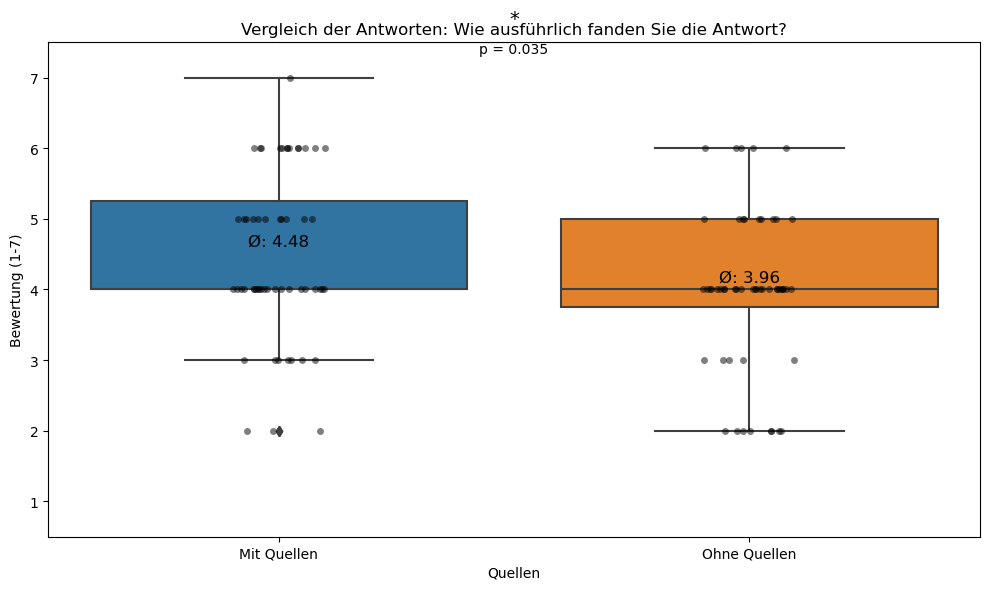

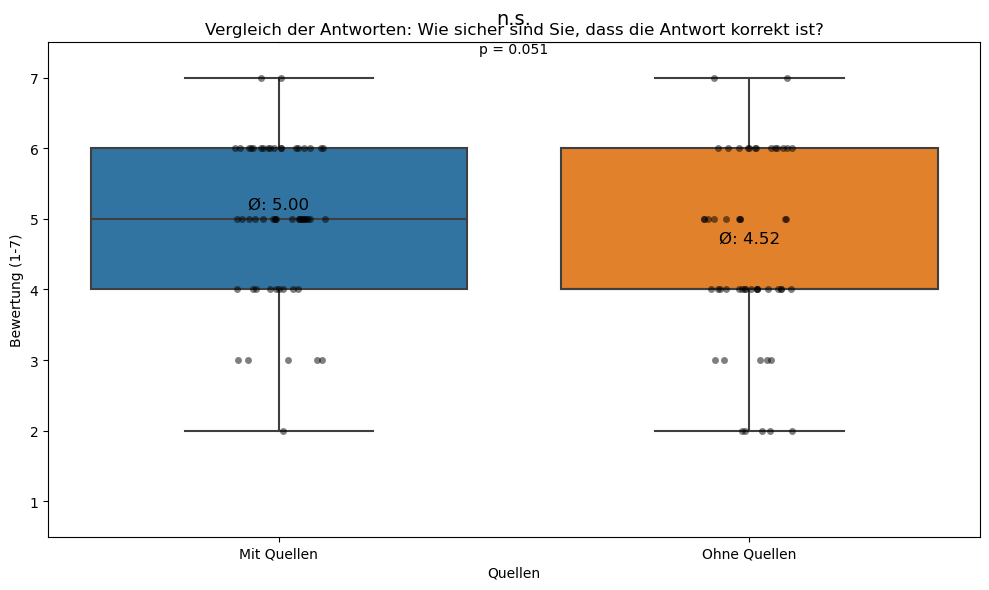

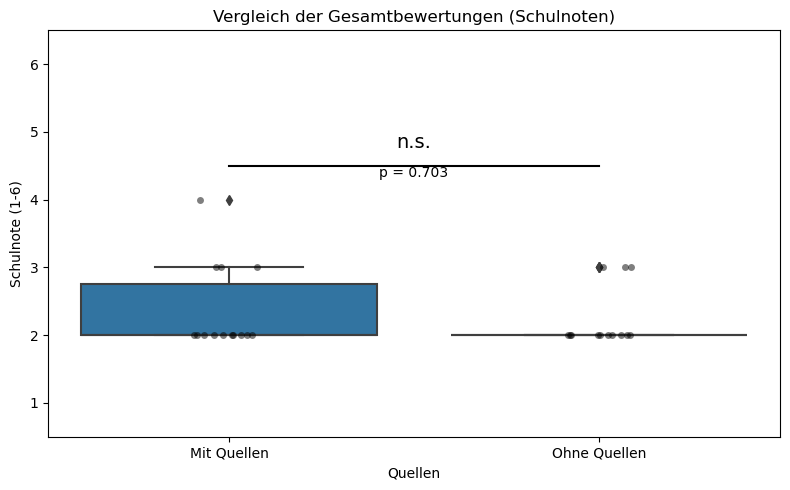

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import mannwhitneyu

# Daten laden
with_sources = pd.read_csv('final_data/with_sources_ati.csv')
without_sources = pd.read_csv('final_data/without_sources_ati.csv')

# Themenbereiche
topics = ['CIA', 'Wirtschaft', 'Gesundheit', 'Physik']

# Fragen (ohne Themenpräfix)
questions = [
    'Wie viel Vorwissen haben Sie zu dem Thema des Textes?',
    'Wie Glaubwürdig fanden Sie die Antwort?',
    'Wie klar und verständlich war die Antwort?',
    'Wie sachlich fanden Sie die Antwort?',
    'Wie sehr vertrauen Sie den in der Antwort präsentierten Informationen?',
    'Wie wahrscheinlich ist es, dass die Antwort missverstanden werden könnte?',
    'Wie ausführlich fanden Sie die Antwort?',
    'Wie sicher sind Sie, dass die Antwort korrekt ist?'
]

# Daten für mit und ohne Quellen vorbereiten
data_with = []
data_without = []

for topic in topics:
    for question in questions:
        col_with = f"{topic} - {question}"
        col_without = f"{topic} - {question}"
        
        # Daten extrahieren
        if col_with in with_sources.columns:
            with_values = with_sources[col_with].dropna()
            data_with.extend([(topic, question, val, 'Mit Quellen') for val in with_values])
        
        if col_without in without_sources.columns:
            without_values = without_sources[col_without].dropna()
            data_without.extend([(topic, question, val, 'Ohne Quellen') for val in without_values])

# DataFrames erstellen
df_with = pd.DataFrame(data_with, columns=['Thema', 'Frage', 'Wert', 'Quellen'])
df_without = pd.DataFrame(data_without, columns=['Thema', 'Frage', 'Wert', 'Quellen'])

# Beide DataFrames kombinieren
df_combined = pd.concat([df_with, df_without])

# Funktion zur Signifikanz-Bewertung
def get_significance_stars(p_value):
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return 'n.s.'

# Plot für jede Frage erstellen mit Signifikanz
for question in questions:
    plt.figure(figsize=(10, 6))
    
    # Daten für die aktuelle Frage filtern
    df_question = df_combined[df_combined['Frage'] == question]
    
    # Boxplot erstellen
    sns.boxplot(x='Quellen', y='Wert', data=df_question)
    
    # Punkte für einzelne Antworten hinzufügen
    sns.stripplot(x='Quellen', y='Wert', data=df_question,
                 color='black', alpha=0.5, jitter=True)
    
    plt.title(f'Vergleich der Antworten: {question}')
    plt.ylabel('Bewertung (1-7)')
    plt.ylim(0.5, 7.5)
    
    # Durchschnittswerte berechnen
    means = df_question.groupby('Quellen')['Wert'].mean()
    
    # Signifikanztest durchführen (Mann-Whitney-U-Test für nicht-normalverteilte Daten)
    group_with = df_question[df_question['Quellen'] == 'Mit Quellen']['Wert']
    group_without = df_question[df_question['Quellen'] == 'Ohne Quellen']['Wert']
    
    try:
        stat, p = mannwhitneyu(group_with, group_without)
        stars = get_significance_stars(p)
        
        # Signifikanzlinie und Annotation hinzufügen
        max_val = df_question['Wert'].max()
        plt.plot([0, 1], [max_val + 0.5, max_val + 0.5], color='black', lw=1.5)
        plt.text(0.5, max_val + 0.7, stars, ha='center', va='bottom', fontsize=14)
        plt.text(0.5, max_val + 0.5, f'p = {p:.3f}', ha='center', va='top', fontsize=10)
    except:
        pass
    
    # Durchschnittswerte anzeigen
    for i, source in enumerate(['Mit Quellen', 'Ohne Quellen']):
        plt.text(i, means[source] + 0.1, f'Ø: {means[source]:.2f}', 
                ha='center', va='bottom', fontsize=12, color='black')
    
    plt.tight_layout()
    plt.show()

# Vergleich der Gesamtbewertungen (Schulnoten) mit Signifikanz
grade_col_with = [col for col in with_sources.columns if 'Schulnoten' in col or 'bewerten' in col]
grade_col_without = [col for col in without_sources.columns if 'Schulnoten' in col or 'bewerten' in col]

if grade_col_with and grade_col_without:
    # Numerische Werte sicherstellen
    grades_with = pd.to_numeric(with_sources[grade_col_with[0]], errors='coerce').dropna()
    grades_without = pd.to_numeric(without_sources[grade_col_without[0]], errors='coerce').dropna()
    
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=pd.DataFrame({
        'Quellen': ['Mit Quellen'] * len(grades_with) + ['Ohne Quellen'] * len(grades_without),
        'Wert': list(grades_with) + list(grades_without)
    }), x='Quellen', y='Wert')
    
    # Punkte für einzelne Noten hinzufügen
    sns.stripplot(data=pd.DataFrame({
        'Quellen': ['Mit Quellen'] * len(grades_with) + ['Ohne Quellen'] * len(grades_without),
        'Wert': list(grades_with) + list(grades_without)
    }), x='Quellen', y='Wert', color='black', alpha=0.5, jitter=True)
    
    # Signifikanztest für Schulnoten
    try:
        stat, p = mannwhitneyu(grades_with, grades_without)
        stars = get_significance_stars(p)
        max_grade = max(max(grades_with), max(grades_without))
        
        plt.plot([0, 1], [max_grade + 0.5, max_grade + 0.5], color='black', lw=1.5)
        plt.text(0.5, max_grade + 0.7, stars, ha='center', va='bottom', fontsize=14)
        plt.text(0.5, max_grade + 0.5, f'p = {p:.3f}', ha='center', va='top', fontsize=10)
    except:
        pass
    
    plt.title('Vergleich der Gesamtbewertungen (Schulnoten)')
    plt.ylabel('Schulnote (1-6)')
    plt.ylim(0.5, 6.5)
    plt.tight_layout()
    plt.show()
else:
    print("Konnte die Spalte mit den Schulnoten nicht finden.")

Korrelationsanalyse zwischen ATI-Score und Glaubwürdigkeit:
Pearson-Korrelation (linearer Zusammenhang): r = 0.185, p = 0.3545
Spearman-Korrelation (monotoner Zusammenhang): ρ = 0.352, p = 0.0718


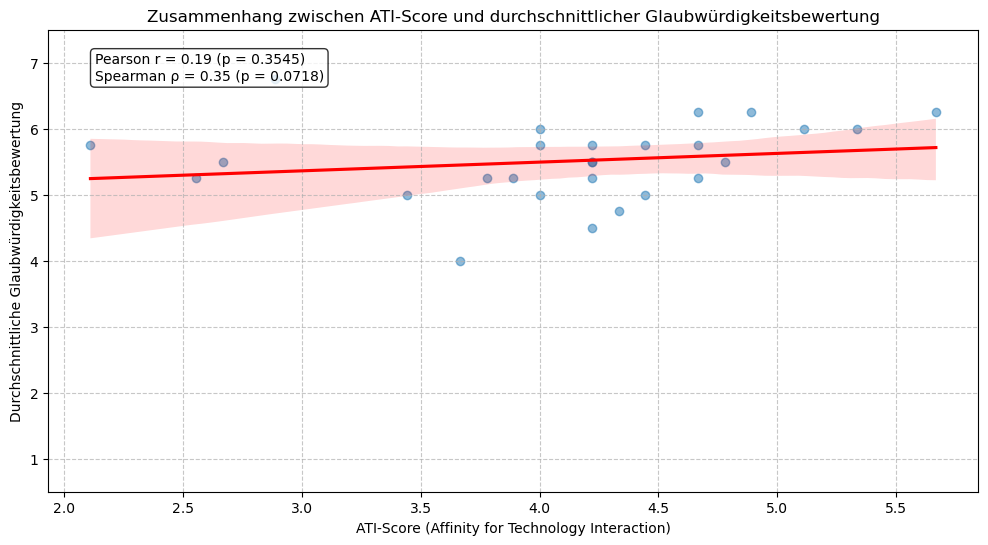


Korrelation nach Gruppen:
Mit Quellen: r = 0.174, p = 0.5513 (n = 14)
Ohne Quellen: r = 0.166, p = 0.5885 (n = 13)


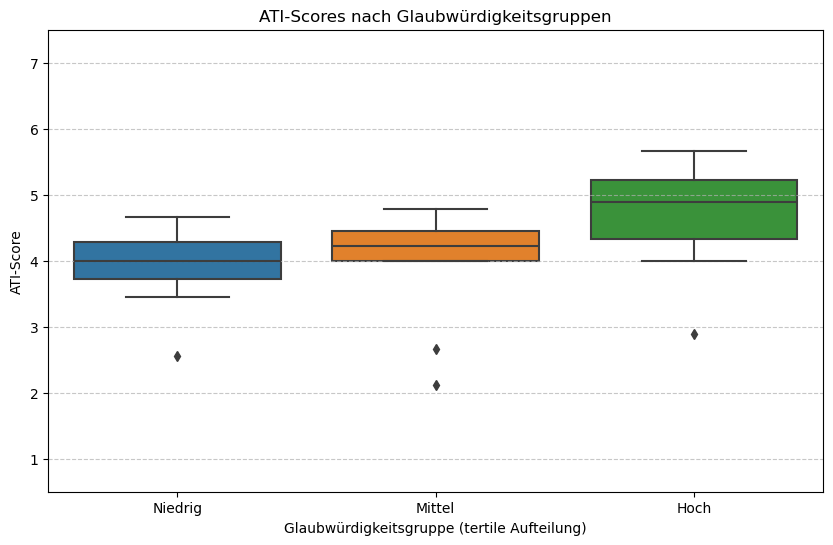

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Beide Datensätze laden und zusammenführen
with_sources = pd.read_csv('final_data/with_sources_ati.csv')
without_sources = pd.read_csv('final_data/without_sources_ati.csv')

# Spalte hinzufügen zur Unterscheidung der Gruppen
with_sources['Gruppe'] = 'Mit Quellen'
without_sources['Gruppe'] = 'Ohne Quellen'

# Daten zusammenführen
combined_data = pd.concat([with_sources, without_sources])

# Durchschnittliche Glaubwürdigkeit pro Teilnehmer berechnen
glaubw_cols = [col for col in combined_data.columns if 'Glaubwürdig' in col]
combined_data['Durchschnittliche_Glaubwürdigkeit'] = combined_data[glaubw_cols].mean(axis=1)

# ATI-Score und Glaubwürdigkeit extrahieren
ati_scores = combined_data['ATI_Score']
glaubw_scores = combined_data['Durchschnittliche_Glaubwürdigkeit']

# NaN-Werte entfernen
valid_indices = ~np.isnan(ati_scores) & ~np.isnan(glaubw_scores)
ati_scores_clean = ati_scores[valid_indices]
glaubw_scores_clean = glaubw_scores[valid_indices]

# Korrelationsanalyse
pearson_r, pearson_p = stats.pearsonr(ati_scores_clean, glaubw_scores_clean)
spearman_r, spearman_p = stats.spearmanr(ati_scores_clean, glaubw_scores_clean)

print("Korrelationsanalyse zwischen ATI-Score und Glaubwürdigkeit:")
print(f"Pearson-Korrelation (linearer Zusammenhang): r = {pearson_r:.3f}, p = {pearson_p:.4f}")
print(f"Spearman-Korrelation (monotoner Zusammenhang): ρ = {spearman_r:.3f}, p = {spearman_p:.4f}")

# Regressionsgerade berechnen
slope, intercept, r_value, p_value, std_err = stats.linregress(ati_scores_clean, glaubw_scores_clean)

# Visualisierung
plt.figure(figsize=(12, 6))

# Scatterplot mit Regressionsgerade
sns.regplot(x=ati_scores_clean, y=glaubw_scores_clean, 
            scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Zusammenhang zwischen ATI-Score und durchschnittlicher Glaubwürdigkeitsbewertung')
plt.xlabel('ATI-Score (Affinity for Technology Interaction)')
plt.ylabel('Durchschnittliche Glaubwürdigkeitsbewertung')
plt.ylim(0.5, 7.5)
plt.grid(True, linestyle='--', alpha=0.7)

# Annotation der Korrelationswerte
plt.text(0.05, 0.95, 
         f"Pearson r = {pearson_r:.2f} (p = {pearson_p:.4f})\nSpearman ρ = {spearman_r:.2f} (p = {spearman_p:.4f})",
         transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.show()

# Gruppierte Analyse nach Quelle
print("\nKorrelation nach Gruppen:")
for group in ['Mit Quellen', 'Ohne Quellen']:
    group_data = combined_data[combined_data['Gruppe'] == group]
    ati = group_data['ATI_Score']
    glaubw = group_data['Durchschnittliche_Glaubwürdigkeit']
    
    valid_idx = ~np.isnan(ati) & ~np.isnan(glaubw)
    ati_clean = ati[valid_idx]
    glaubw_clean = glaubw[valid_idx]
    
    if len(ati_clean) > 2:  # Mindestens 3 Punkte für Korrelation benötigt
        r, p = stats.pearsonr(ati_clean, glaubw_clean)
        print(f"{group}: r = {r:.3f}, p = {p:.4f} (n = {len(ati_clean)})")
    else:
        print(f"{group}: Nicht genügend Daten für Korrelationsberechnung")

# Boxplot der ATI-Scores nach Glaubwürdigkeitsgruppen
plt.figure(figsize=(10, 6))
combined_data['Glaubwürdigkeitsgruppe'] = pd.qcut(combined_data['Durchschnittliche_Glaubwürdigkeit'], 
                                                 q=3, 
                                                 labels=['Niedrig', 'Mittel', 'Hoch'])
sns.boxplot(x='Glaubwürdigkeitsgruppe', y='ATI_Score', data=combined_data)
plt.title('ATI-Scores nach Glaubwürdigkeitsgruppen')
plt.xlabel('Glaubwürdigkeitsgruppe (tertile Aufteilung)')
plt.ylabel('ATI-Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0.5, 7.5)
plt.show()

/var/folders/fg/mnsxwcgd44d0d911s38ny_f80000gn/T/ipykernel_1460/1451628856.py:15: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df['Glaubwürdigkeit'] = df[cred_cols].mean(axis=1)
/var/folders/fg/mnsxwcgd44d0d911s38ny_f80000gn/T/ipykernel_1460/1451628856.py:15: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df['Glaubwürdigkeit'] = df[cred_cols].mean(axis=1)


<Figure size 1200x600 with 0 Axes>

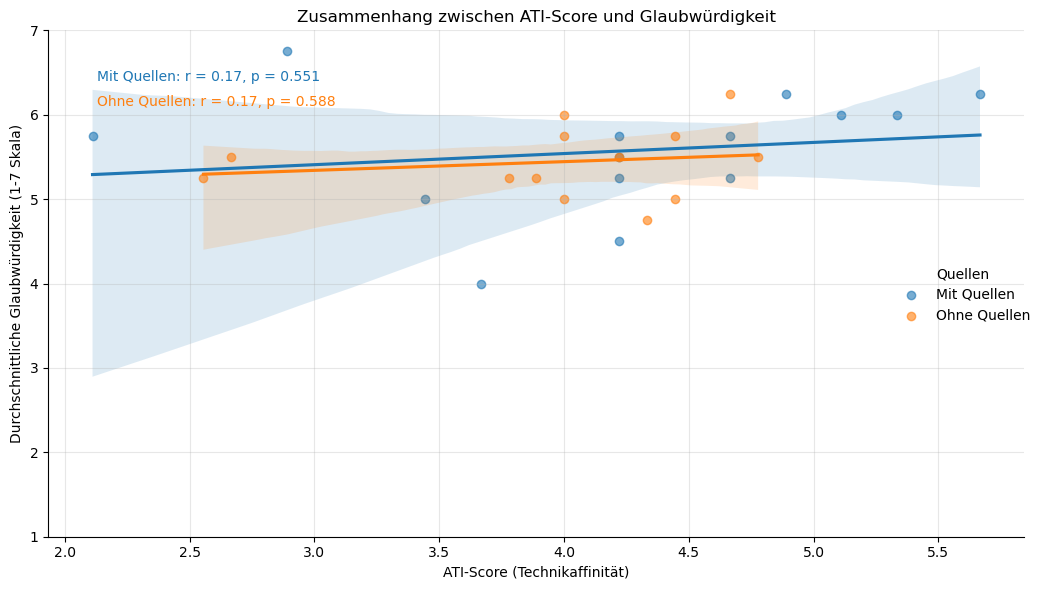

Statistische Kennwerte:

Mit Quellen:
- Korrelation (r): 0.17
- p-Wert: 0.5513
- Anzahl: 14
- M (Glaubwürdigkeit): 5.57 ± 0.73
- M (ATI): 4.24 ± 0.96

Ohne Quellen:
- Korrelation (r): 0.17
- p-Wert: 0.5885
- Anzahl: 13
- M (Glaubwürdigkeit): 5.44 ± 0.42
- M (ATI): 3.98 ± 0.68

Vergleich der Glaubwürdigkeit (mit vs. ohne Quellen):
t = 0.57, p = 0.5765


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import pearsonr

# Daten laden
with_sources = pd.read_csv('final_data/with_sources_ati.csv')
without_sources = pd.read_csv('final_data/without_sources_ati.csv')

# Funktion zur Extraktion der Glaubwürdigkeitsbewertungen
def extract_credibility(df):
    cred_cols = [col for col in df.columns if 'Glaubwürdig' in col]
    df['Glaubwürdigkeit'] = df[cred_cols].mean(axis=1)
    return df[['Glaubwürdigkeit', 'ATI_Score']]

# Daten vorbereiten
with_sources_clean = extract_credibility(with_sources).assign(Quellen='Mit Quellen')
without_sources_clean = extract_credibility(without_sources).assign(Quellen='Ohne Quellen')
combined = pd.concat([with_sources_clean, without_sources_clean])

# Korrelationen berechnen
corr_with = pearsonr(with_sources_clean['ATI_Score'], with_sources_clean['Glaubwürdigkeit'])
corr_without = pearsonr(without_sources_clean['ATI_Score'], without_sources_clean['Glaubwürdigkeit'])

# Plot erstellen
plt.figure(figsize=(12, 6))

# Scatterplot mit Regressionslinien
sns.lmplot(x='ATI_Score', y='Glaubwürdigkeit', hue='Quellen', 
           data=combined, height=6, aspect=1.5,
           palette={'Mit Quellen': '#1f77b4', 'Ohne Quellen': '#ff7f0e'},
           scatter_kws={'alpha': 0.6})

plt.title('Zusammenhang zwischen ATI-Score und Glaubwürdigkeit')
plt.xlabel('ATI-Score (Technikaffinität)')
plt.ylabel('Durchschnittliche Glaubwürdigkeit (1-7 Skala)')
plt.grid(alpha=0.3)
plt.ylim(1, 7)

# Korrelationswerte annotieren
plt.text(0.05, 0.9, 
         f"Mit Quellen: r = {corr_with[0]:.2f}, p = {corr_with[1]:.3f}", 
         transform=plt.gca().transAxes,
         color='#1f77b4')
plt.text(0.05, 0.85, 
         f"Ohne Quellen: r = {corr_without[0]:.2f}, p = {corr_without[1]:.3f}", 
         transform=plt.gca().transAxes,
         color='#ff7f0e')

plt.tight_layout()
plt.show()

# Deskriptive Statistiken ausgeben
print("Statistische Kennwerte:")
print("\nMit Quellen:")
print(f"- Korrelation (r): {corr_with[0]:.2f}")
print(f"- p-Wert: {corr_with[1]:.4f}")
print(f"- Anzahl: {len(with_sources_clean)}")
print(f"- M (Glaubwürdigkeit): {with_sources_clean['Glaubwürdigkeit'].mean():.2f} ± {with_sources_clean['Glaubwürdigkeit'].std():.2f}")
print(f"- M (ATI): {with_sources_clean['ATI_Score'].mean():.2f} ± {with_sources_clean['ATI_Score'].std():.2f}")

print("\nOhne Quellen:")
print(f"- Korrelation (r): {corr_without[0]:.2f}")
print(f"- p-Wert: {corr_without[1]:.4f}")
print(f"- Anzahl: {len(without_sources_clean)}")
print(f"- M (Glaubwürdigkeit): {without_sources_clean['Glaubwürdigkeit'].mean():.2f} ± {without_sources_clean['Glaubwürdigkeit'].std():.2f}")
print(f"- M (ATI): {without_sources_clean['ATI_Score'].mean():.2f} ± {without_sources_clean['ATI_Score'].std():.2f}")

# Zusätzliche Analyse: Unterschied in den Mittelwerten
t_stat, p_val = stats.ttest_ind(
    with_sources_clean['Glaubwürdigkeit'],
    without_sources_clean['Glaubwürdigkeit'],
    equal_var=False
)
print(f"\nVergleich der Glaubwürdigkeit (mit vs. ohne Quellen):")
print(f"t = {t_stat:.2f}, p = {p_val:.4f}")

<Figure size 1200x600 with 0 Axes>

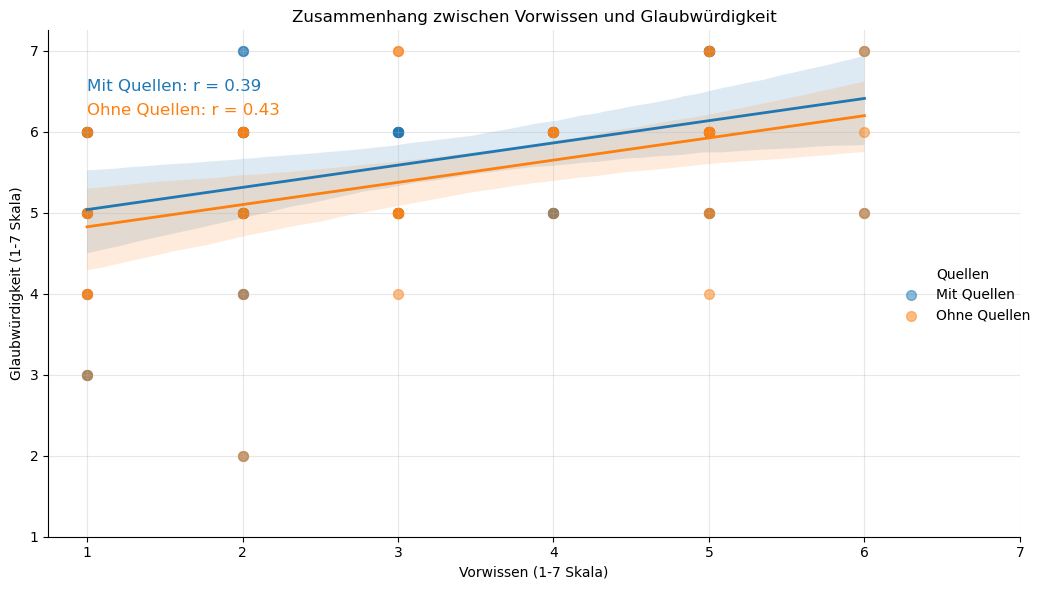


Korrelationen nach Thema und Quellenangabe:
     Quellen      Thema  Korrelation (r)   p-Wert  Stichprobengröße
 Mit Quellen        CIA         0.568722 0.033814              14.0
 Mit Quellen Gesundheit         0.357685 0.209257              14.0
 Mit Quellen     Physik         0.568722 0.033814              14.0
 Mit Quellen Wirtschaft         0.065339 0.824379              14.0
Ohne Quellen        CIA         0.541482 0.055978              13.0
Ohne Quellen Gesundheit         0.431556 0.140896              13.0
Ohne Quellen     Physik         0.248334 0.413302              13.0
Ohne Quellen Wirtschaft         0.431556 0.140896              13.0

Gesamtkorrelationen:
Mit Quellen: r = 0.39
Ohne Quellen: r = 0.43

Vergleich der Korrelationen (Fisher's z-Test):
z = -0.27, p = 0.7870


In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import pearsonr

# Daten einlesen
with_sources = pd.read_csv('final_data/with_sources_ati.csv')
without_sources = pd.read_csv('final_data/without_sources_ati.csv')

# Funktion zur Extraktion von Vorwissen und Glaubwürdigkeit
def extract_knowledge_credibility(df):
    # Vorwissen-Spalten (1. Frage jedes Themas)
    knowledge_cols = [
        'CIA - Wie viel Vorwissen haben Sie zu dem Thema des Textes?',
        'Wirtschaft - Wie viel Vorwissen haben Sie zu dem Thema des Textes?',
        'Gesundheit - Wie viel Vorwissen haben Sie zu dem Thema des Textes?',
        'Physik - Wie viel Vorwissen haben Sie zu dem Thema des Textes?'
    ]
    
    # Glaubwürdigkeits-Spalten (2. Frage jedes Themas)
    credibility_cols = [
        'CIA - Wie Glaubwürdig fanden Sie die Antwort?',
        'Wirtschaft - Wie Glaubwürdig fanden Sie die Antwort?',
        'Gesundheit - Wie Glaubwürdig fanden Sie die Antwort?',
        'Physik - Wie Glaubwürdig fanden Sie die Antwort?'
    ]
    
    # Daten in langes Format umwandeln
    knowledge = df[knowledge_cols].melt(var_name='Thema', value_name='Vorwissen')
    credibility = df[credibility_cols].melt(var_name='Thema', value_name='Glaubwürdigkeit')
    
    # Daten kombinieren
    combined = pd.concat([knowledge['Vorwissen'], credibility['Glaubwürdigkeit']], axis=1)
    combined['Thema'] = knowledge['Thema'].str.extract(r'^(.*?) - ')[0]
    
    return combined

# Daten vorbereiten
with_sources_data = extract_knowledge_credibility(with_sources).assign(Quellen='Mit Quellen')
without_sources_data = extract_knowledge_credibility(without_sources).assign(Quellen='Ohne Quellen')
all_data = pd.concat([with_sources_data, without_sources_data]).dropna()

# Korrelationen berechnen
corr_with = all_data[all_data['Quellen'] == 'Mit Quellen'][['Vorwissen', 'Glaubwürdigkeit']].corr().iloc[0,1]
corr_without = all_data[all_data['Quellen'] == 'Ohne Quellen'][['Vorwissen', 'Glaubwürdigkeit']].corr().iloc[0,1]

# Scatterplot mit Regressionslinien
plt.figure(figsize=(12, 6))
sns.lmplot(x='Vorwissen', y='Glaubwürdigkeit', hue='Quellen', 
           data=all_data, height=6, aspect=1.5,
           palette={'Mit Quellen': '#1f77b4', 'Ohne Quellen': '#ff7f0e'},
           scatter_kws={'alpha': 0.5, 's': 50},
           line_kws={'linewidth': 2})

plt.title('Zusammenhang zwischen Vorwissen und Glaubwürdigkeit')
plt.xlabel('Vorwissen (1-7 Skala)')
plt.ylabel('Glaubwürdigkeit (1-7 Skala)')
plt.xticks(range(1, 8))
plt.yticks(range(1, 8))
plt.grid(alpha=0.3)

# Korrelationswerte annotieren
plt.text(1, 6.5, 
         f"Mit Quellen: r = {corr_with:.2f}", 
         color='#1f77b4', fontsize=12)
plt.text(1, 6.2, 
         f"Ohne Quellen: r = {corr_without:.2f}", 
         color='#ff7f0e', fontsize=12)

plt.tight_layout()
plt.show()

# Statistische Tests durchführen
def calculate_correlation_stats(group_data):
    r, p = pearsonr(group_data['Vorwissen'], group_data['Glaubwürdigkeit'])
    n = len(group_data)
    return pd.Series({'Korrelation (r)': r, 'p-Wert': p, 'Stichprobengröße': n})

# Ergebnisse nach Quelle und Thema
results = all_data.groupby(['Quellen', 'Thema']).apply(calculate_correlation_stats).reset_index()
print("\nKorrelationen nach Thema und Quellenangabe:")
print(results.to_string(index=False))

# Gesamtergebnisse
print("\nGesamtkorrelationen:")
print(f"Mit Quellen: r = {corr_with:.2f}")
print(f"Ohne Quellen: r = {corr_without:.2f}")

# Unterschied zwischen den Korrelationen testen (Fisher's z-Transformation)
def compare_correlations(r1, r2, n1, n2):
    z1 = np.arctanh(r1)
    z2 = np.arctanh(r2)
    se_diff = np.sqrt(1/(n1-3) + 1/(n2-3))
    z = (z1 - z2)/se_diff
    p = 2 * (1 - stats.norm.cdf(abs(z)))
    return z, p

z_score, p_value = compare_correlations(corr_with, corr_without, 
                                       len(with_sources_data), 
                                       len(without_sources_data))
print(f"\nVergleich der Korrelationen (Fisher's z-Test):")
print(f"z = {z_score:.2f}, p = {p_value:.4f}")

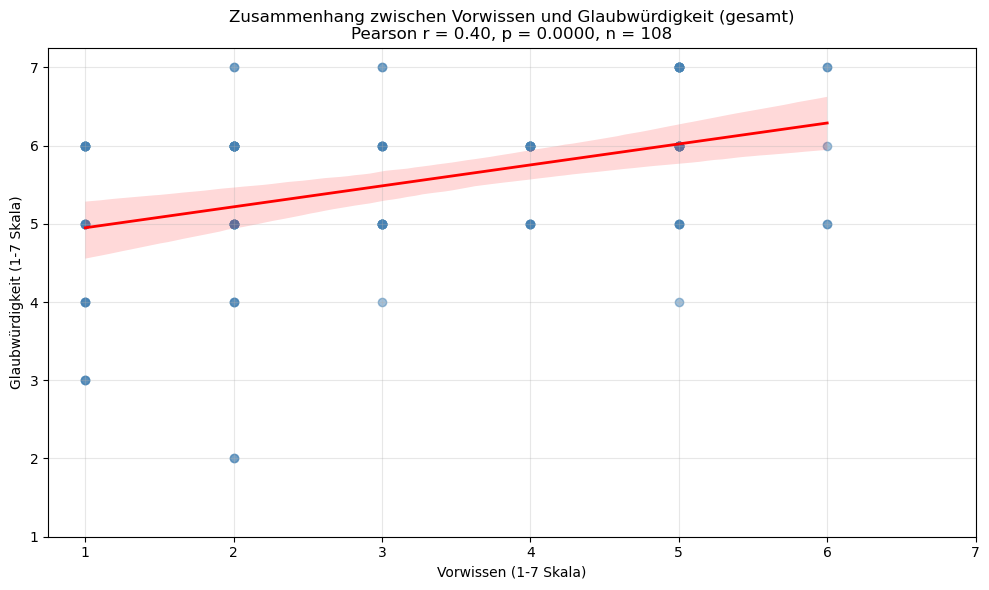

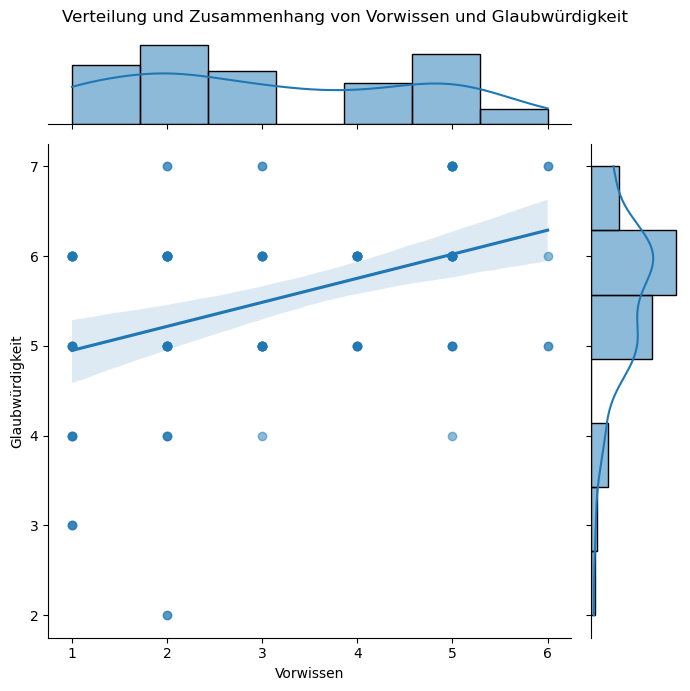


Statistische Analyse des Zusammenhangs:
Pearson-Korrelationskoeffizient: r = 0.400
Signifikanzniveau: p = 0.0000
Stichprobengröße: n = 108
Effektstärkeinterpretation: moderater Zusammenhang

Zusätzliche deskriptive Statistiken:
       Vorwissen  Glaubwürdigkeit
count     108.00           108.00
mean        3.09             5.51
std         1.56             1.05
min         1.00             2.00
25%         2.00             5.00
50%         3.00             6.00
75%         5.00             6.00
max         6.00             7.00

Korrelationsmatrix:
                 Vorwissen  Glaubwürdigkeit
Vorwissen              1.0              0.4
Glaubwürdigkeit        0.4              1.0


In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import pearsonr

# Daten einlesen
with_sources = pd.read_csv('final_data/with_sources_ati.csv')
without_sources = pd.read_csv('final_data/without_sources_ati.csv')

# Funktion zur Extraktion aller Vorwissen-Glaubwürdigkeits-Paare
def extract_all_knowledge_credibility(df):
    knowledge_values = []
    credibility_values = []
    
    # Alle Themen durchgehen
    topics = ['CIA', 'Wirtschaft', 'Gesundheit', 'Physik']
    
    for topic in topics:
        knowledge_col = f"{topic} - Wie viel Vorwissen haben Sie zu dem Thema des Textes?"
        credibility_col = f"{topic} - Wie Glaubwürdig fanden Sie die Antwort?"
        
        if knowledge_col in df.columns and credibility_col in df.columns:
            knowledge = df[knowledge_col].dropna()
            credibility = df[credibility_col].dropna()
            
            # Gleiche Länge sicherstellen
            min_len = min(len(knowledge), len(credibility))
            knowledge_values.extend(knowledge[:min_len])
            credibility_values.extend(credibility[:min_len])
    
    return pd.DataFrame({
        'Vorwissen': knowledge_values,
        'Glaubwürdigkeit': credibility_values
    })

# Daten kombinieren (ohne Berücksichtigung von Quellen oder Themen)
all_data = pd.concat([
    extract_all_knowledge_credibility(with_sources),
    extract_all_knowledge_credibility(without_sources)
]).dropna()

# Korrelation berechnen
corr_coef, p_value = pearsonr(all_data['Vorwissen'], all_data['Glaubwürdigkeit'])
n = len(all_data)

# Hilfsfunktion zur Interpretation der Effektstärke
def describe_correlation(r):
    abs_r = abs(r)
    if abs_r >= 0.5:
        return "starker Zusammenhang"
    elif abs_r >= 0.3:
        return "moderater Zusammenhang"
    elif abs_r >= 0.1:
        return "schwacher Zusammenhang"
    else:
        return "kein nennenswerter Zusammenhang"

# Scatterplot mit Regressionslinie
plt.figure(figsize=(10, 6))
sns.regplot(x='Vorwissen', y='Glaubwürdigkeit', data=all_data,
            scatter_kws={'alpha': 0.5, 'color': 'steelblue'},
            line_kws={'color': 'red', 'linewidth': 2})

plt.title(f'Zusammenhang zwischen Vorwissen und Glaubwürdigkeit (gesamt)\nPearson r = {corr_coef:.2f}, p = {p_value:.4f}, n = {n}')
plt.xlabel('Vorwissen (1-7 Skala)')
plt.ylabel('Glaubwürdigkeit (1-7 Skala)')
plt.xticks(range(1, 8))
plt.yticks(range(1, 8))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Jointplot mit Randverteilungen
joint_plot = sns.jointplot(x='Vorwissen', y='Glaubwürdigkeit', data=all_data,
                          kind='reg', height=7,
                          joint_kws={'scatter_kws': {'alpha': 0.5}},
                          marginal_kws={'bins': 7})
joint_plot.fig.suptitle('Verteilung und Zusammenhang von Vorwissen und Glaubwürdigkeit')
plt.tight_layout()
plt.show()

# Ergebnisse ausgeben
print("\nStatistische Analyse des Zusammenhangs:")
print(f"Pearson-Korrelationskoeffizient: r = {corr_coef:.3f}")
print(f"Signifikanzniveau: p = {p_value:.4f}")
print(f"Stichprobengröße: n = {n}")
print(f"Effektstärkeinterpretation: {describe_correlation(corr_coef)}")

# Zusätzliche deskriptive Statistiken
print("\nZusätzliche deskriptive Statistiken:")
print(all_data.describe().round(2))

# Korrelationsmatrix (nur zur Demonstration, da wir nur zwei Variablen haben)
print("\nKorrelationsmatrix:")
print(all_data.corr().round(3))

Fehler bei Tukey-Test für Klarheit: too many indices for array: array is 1-dimensional, but 2 were indexed
Fehler bei Tukey-Test für Sachlichkeit: too many indices for array: array is 1-dimensional, but 2 were indexed


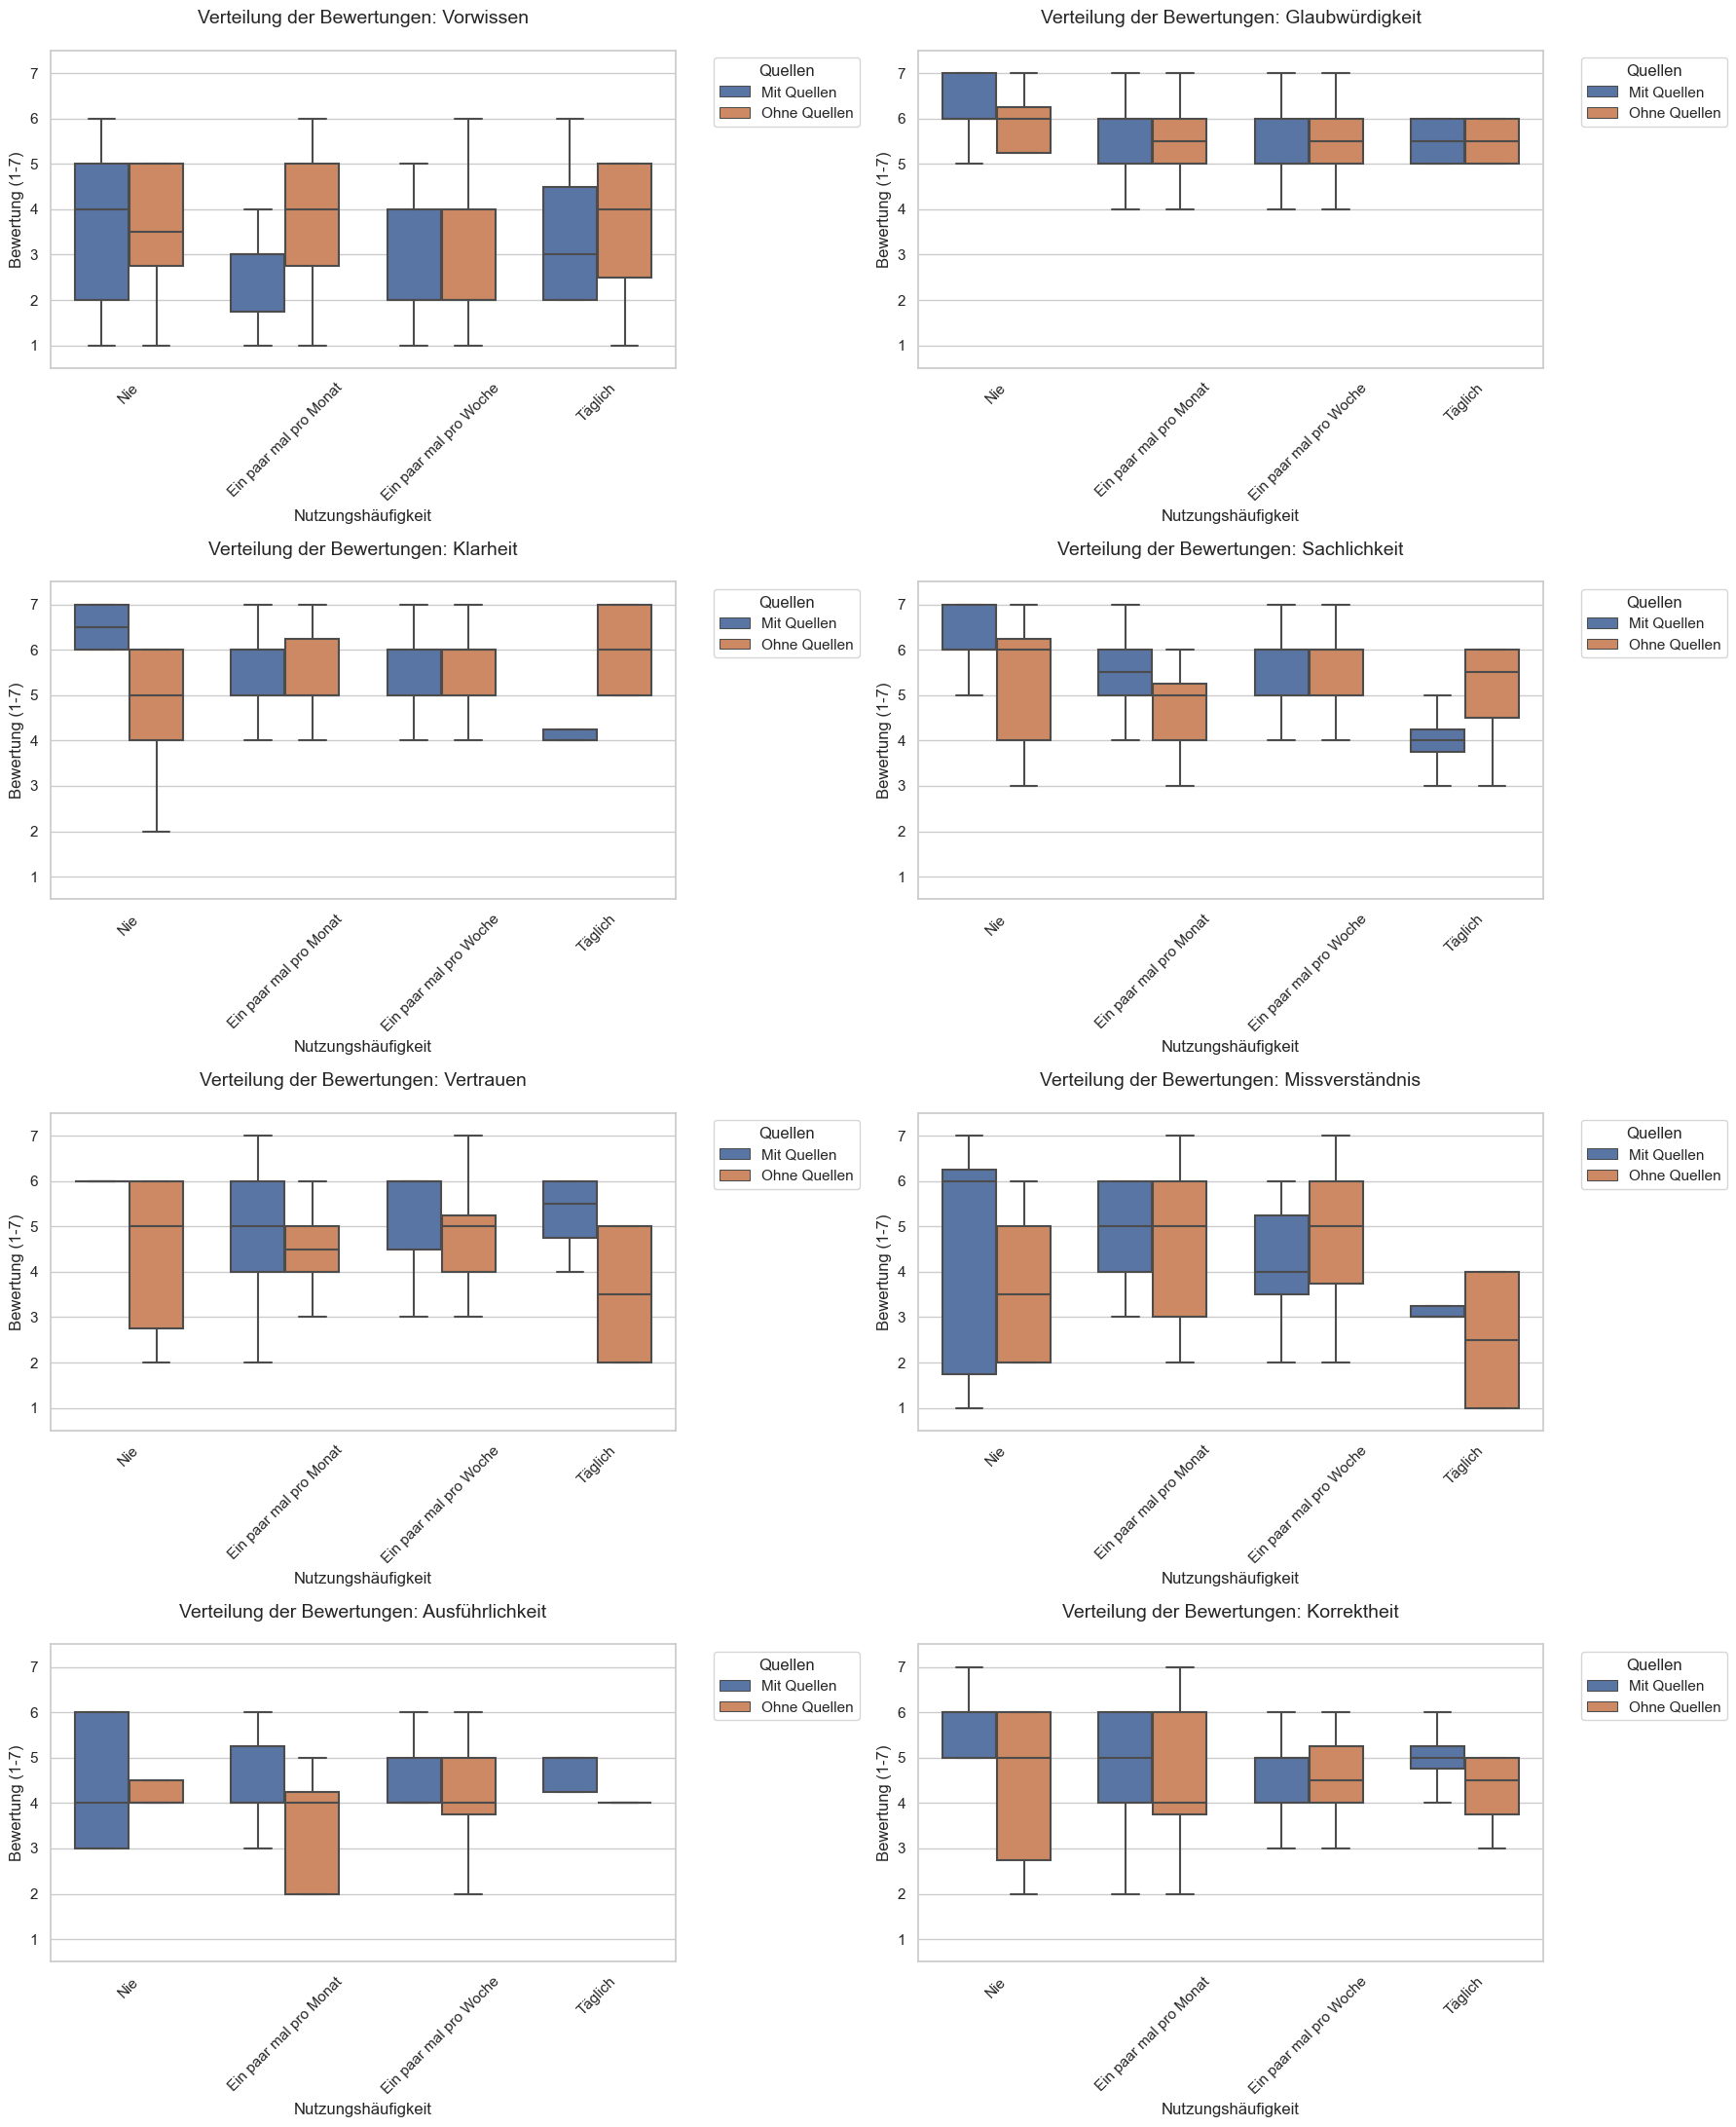

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import numpy as np

# Daten einlesen
with_sources = pd.read_csv('final_data/with_sources_ati.csv')
without_sources = pd.read_csv('final_data/without_sources_ati.csv')

# Spalten umbenennen für einfachere Handhabung
columns_1_8 = ['Vorwissen', 'Glaubwürdigkeit', 'Klarheit', 'Sachlichkeit', 
               'Vertrauen', 'Missverständnis', 'Ausführlichkeit', 'Korrektheit']

# Definieren Sie die gewünschte Reihenfolge der Nutzungshäufigkeit
nutzung_order = ['Nie', 'Ein paar mal pro Monat', 'Ein paar mal pro Woche', 'Täglich']

# Funktion zur Vorbereitung der Daten
def prepare_data(df, has_sources=True):
    topics = ['CIA', 'Wirtschaft', 'Gesundheit', 'Physik']
    data = []
    
    for topic in topics:
        topic_cols = [f"{topic} - {col}" for col in [
            "Wie viel Vorwissen haben Sie zu dem Thema des Textes?",
            "Wie Glaubwürdig fanden Sie die Antwort?",
            "Wie klar und verständlich war die Antwort?",
            "Wie sachlich fanden Sie die Antwort?",
            "Wie sehr vertrauen Sie den in der Antwort präsentierten Informationen?",
            "Wie wahrscheinlich ist es, dass die Antwort missverstanden werden könnte?",
            "Wie ausführlich fanden Sie die Antwort?",
            "Wie sicher sind Sie, dass die Antwort korrekt ist?"
        ]]
        
        topic_data = df[topic_cols].copy()
        topic_data.columns = columns_1_8
        topic_data['Thema'] = topic
        topic_data['Nutzungshäufigkeit'] = df['Wie oft nutzen Sie KI-Chat-Systeme zur Informationsbeschaffung?']
        data.append(topic_data)
    
    combined = pd.concat(data)
    combined['Hat Quellen'] = 'Mit Quellen' if has_sources else 'Ohne Quellen'
    
    # Konvertieren Sie die Nutzungshäufigkeit in eine geordnete Kategorie
    combined['Nutzungshäufigkeit'] = pd.Categorical(
        combined['Nutzungshäufigkeit'],
        categories=nutzung_order,
        ordered=True
    )
    
    return combined

# Daten vorbereiten
with_sources_prepared = prepare_data(with_sources, True)
without_sources_prepared = prepare_data(without_sources, False)
all_data = pd.concat([with_sources_prepared, without_sources_prepared])

# Funktion zur Berechnung und Anzeige von Signifikanzen
def add_stat_annotation(ax, data, x, y, order):
    # Nur Gruppen mit Daten berücksichtigen
    present_groups = [group for group in order if group in data[x].unique()]
    
    # Mindestens 2 Gruppen benötigt für Vergleich
    if len(present_groups) < 2:
        return
    
    # Kruskal-Wallis Test
    groups = [data[data[x] == nutzung][y] for nutzung in present_groups]
    h_stat, p_value = stats.kruskal(*groups)
    
    if p_value < 0.05:  # Wenn signifikante Unterschiede vorhanden
        # Post-hoc Test (Tukey HSD)
        try:
            tukey = pairwise_tukeyhsd(data[y], data[x])
            
            # Signifikante Paare finden
            sig_pairs = []
            for i in range(len(tukey.groups)):
                for j in range(i+1, len(tukey.groups)):
                    if tukey.pvalues[i,j] < 0.05:
                        sig_pairs.append((tukey.groups[i], tukey.groups[j]))
            
            # Signifikanzlinien zeichnen
            y_max = data[y].max()
            y_range = data[y].max() - data[y].min()
            bracket_level = 1.05
            
            for pair in sig_pairs:
                # Positionen der Paare
                x1 = order.index(pair[0])
                x2 = order.index(pair[1])
                
                # Linienhöhe
                line_y = y_max + bracket_level * 0.05 * y_range
                bracket_height = 0.03 * y_range
                
                # Horizontale Linie zeichnen
                ax.plot([x1, x1, x2, x2], 
                        [line_y, line_y + bracket_height, line_y + bracket_height, line_y], 
                        lw=1, color='black')
                
                # Sternchen für Signifikanz
                ax.text((x1+x2)*0.5, line_y + bracket_height, '*', 
                        ha='center', va='bottom', color='black', fontsize=12)
                
                bracket_level += 0.15
            
            # p-Wert im Plot anzeigen
            ax.text(0.95, 0.95, f'p = {p_value:.3f}', 
                    transform=ax.transAxes, ha='right', va='top',
                    bbox=dict(facecolor='white', alpha=0.8))
        
        except Exception as e:
            print(f"Fehler bei Tukey-Test für {y}: {str(e)}")

# Plot erstellen
plt.figure(figsize=(18, 22))
sns.set_theme(style="whitegrid")
plt.rcParams['font.size'] = 12

for i, col in enumerate(columns_1_8, 1):
    plt.subplot(4, 2, i)
    ax = sns.boxplot(
        data=all_data, 
        x='Nutzungshäufigkeit', 
        y=col, 
        order=nutzung_order,
        hue='Hat Quellen',
        palette=['#4c72b0', '#dd8452'],
        showfliers=False,
        width=0.7
    )
    
    plt.title(f'Verteilung der Bewertungen: {col}', fontsize=14, pad=20)
    plt.ylim(0.5, 7.5)
    plt.ylabel('Bewertung (1-7)', fontsize=12)
    plt.xlabel('Nutzungshäufigkeit', fontsize=12)
    plt.xticks(rotation=45)
    
    # Signifikanz für jede Gruppe separat berechnen
    for source in ['Mit Quellen', 'Ohne Quellen']:
        subset = all_data[all_data['Hat Quellen'] == source]
        add_stat_annotation(ax, subset, 'Nutzungshäufigkeit', col, nutzung_order)
    
    # Legende positionieren
    plt.legend(title='Quellen', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()

plt.show()

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import numpy as np

# [Daten einlesen und Vorbereitung wie zuvor...]

# Funktion zur Berechnung und Ausgabe der statistischen Tests
def calculate_and_print_stats(data, x, y, group_name):
    present_groups = [group for group in nutzung_order 
                     if group in data[x].unique() and len(data[data[x] == group]) >= 3]
    
    if len(present_groups) < 2:
        print(f"\nKeine ausreichenden Daten für {y} ({group_name})")
        return
    
    # Kruskal-Wallis Test
    groups = [data[data[x] == nutzung][y].dropna() for nutzung in present_groups]
    try:
        h_stat, p_value = stats.kruskal(*groups)
    except Exception as e:
        print(f"\nFehler bei Kruskal-Wallis für {y} ({group_name}): {str(e)}")
        return
    
    print(f"\n=== Ergebnisse für {y} ({group_name}) ===")
    print(f"Kruskal-Wallis Test: H = {h_stat:.3f}, p = {p_value:.4f}")
    
    if p_value < 0.05:
        # Post-hoc Test (Tukey HSD)
        try:
            tukey = pairwise_tukeyhsd(data[y].dropna(), data[x])
            print("\nTukey HSD Post-hoc Test:")
            
            # Ausgabe formatieren
            if hasattr(tukey, 'summary'):
                print(tukey.summary())
            else:
                for i in range(len(tukey.groups)):
                    for j in range(i+1, len(tukey.groups)):
                        print(f"{tukey.groups[i]} vs {tukey.groups[j]}: "
                              f"p = {tukey.pvalues[i,j]:.4f}")
        except Exception as e:
            print(f"Fehler bei Tukey-Test: {str(e)}")
    else:
        print("Keine signifikanten Unterschiede zwischen den Gruppen (p ≥ 0.05)")

# Statistische Tests für alle Fragen durchführen
print("="*80)
print("STATISTISCHE AUSWERTUNG DER UNTERSCHIEDE NACH NUTZUNGSHÄUFIGKEIT")
print("="*80)

for col in columns_1_8:
    # Tests für Gruppe mit Quellen
    subset = all_data[all_data['Hat Quellen'] == 'Mit Quellen']
    calculate_and_print_stats(subset, 'Nutzungshäufigkeit', col, 'Mit Quellen')
    
    # Tests für Gruppe ohne Quellen
    subset = all_data[all_data['Hat Quellen'] == 'Ohne Quellen']
    calculate_and_print_stats(subset, 'Nutzungshäufigkeit', col, 'Ohne Quellen')

# [Boxplot-Erstellung wie zuvor...]

STATISTISCHE AUSWERTUNG DER UNTERSCHIEDE NACH NUTZUNGSHÄUFIGKEIT

=== Ergebnisse für Vorwissen (Mit Quellen) ===
Kruskal-Wallis Test: H = 4.707, p = 0.1946
Keine signifikanten Unterschiede zwischen den Gruppen (p ≥ 0.05)

=== Ergebnisse für Vorwissen (Ohne Quellen) ===
Kruskal-Wallis Test: H = 3.531, p = 0.3168
Keine signifikanten Unterschiede zwischen den Gruppen (p ≥ 0.05)

=== Ergebnisse für Glaubwürdigkeit (Mit Quellen) ===
Kruskal-Wallis Test: H = 7.337, p = 0.0619
Keine signifikanten Unterschiede zwischen den Gruppen (p ≥ 0.05)

=== Ergebnisse für Glaubwürdigkeit (Ohne Quellen) ===
Kruskal-Wallis Test: H = 0.740, p = 0.8638
Keine signifikanten Unterschiede zwischen den Gruppen (p ≥ 0.05)

=== Ergebnisse für Klarheit (Mit Quellen) ===
Kruskal-Wallis Test: H = 9.953, p = 0.0190

Tukey HSD Post-hoc Test:
                Multiple Comparison of Means - Tukey HSD, FWER=0.05                 
        group1                 group2         meandiff p-adj   lower   upper  reject
-----------